In [239]:
import ete3
import pandas as pd
import numpy as np
import subprocess
import itertools
from scipy.spatial.distance import squareform
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.cluster import hierarchy
import multiprocessing

In [42]:
%cd /work/kelsey/hgt/

/work/kelsey/hgt


In [4]:
species_tree = ete3.Tree('species_tree_named_nodes', format=1)

In [43]:
transfer_df = pd.read_csv('transfers-filtered_by_confidence.tab', sep='\t', index_col=0)
transfer_df.head()

,bipartition_support,donor,donor_map,ranger_confidence,ranger_confidence_donor,ranger_confidence_recipient,recipient,recipient_map,family
21,100.0,n76,m75,1.0,1.0,1.0,n79,m76,4468_BAB72593.1-GCA_000009705.1
33,95.0,n101,m83,1.0,1.0,1.0,n105,m91,6335_BAB74460.1-GCA_000009705.1
50,100.0,n153,m60,1.0,1.0,1.0,n158,m64,8868_BAB76993.1-GCA_000009705.1
70,100.0,n76,m7,1.0,1.0,1.0,n108,m8,5056_BAB73181.1-GCA_000009705.1
76,100.0,n155,m10,1.0,1.0,1.0,n8,m11,7453_BAB75578.1-GCA_000009705.1


In [601]:
transfer_df.shape

(815, 10)

In [8]:
donor_recipients = transfer_df.groupby(['donor', 'recipient'])

In [12]:
donor_recipient_distances = {}
for donor, recipient in donor_recipients.groups.keys():
    donor_recipient_distances[(donor, recipient)] = species_tree.get_distance(donor, recipient)

In [45]:
for (donor, recipient), distance in donor_recipient_distances.items():
    transfer_df.loc[(transfer_df.donor==donor) &
                    (transfer_df.recipient==recipient), 'transfer_distance'] = distance

In [313]:
%cd /work/kelsey/hgt/maxtic_test/
distance_thresholds = np.linspace(np.min(list(donor_recipient_distances.values())),
                                  1.95,
                                  20,
                                  endpoint=False)

/work/kelsey/hgt/maxtic_test


In [250]:
def run_maxtic_with_dist_threshold(thresh=0):
    tmp_df = transfer_df[transfer_df.transfer_distance>=thresh].copy()
    
    out = open('maxtic_%.4f.input' % thresh, 'w')
    for index, row in tmp_df[['donor', 'recipient']].iterrows():
        out.write('%s\n' % '\t'.join(row.tolist()))
    out.close()
    
    subprocess.call(['python2.7', #needs py27... let's see for how long it will keep working...
                     '/work/ale/maxtic/MaxTiC.py',
                     '../species_tree_named_nodes',
                     'maxtic_%.4f.input' % thresh,
                     'ls=180' #this is the value used in their paper and suggested in the documentation
                 ])

In [314]:
pool = multiprocessing.Pool(processes=15)
pool.map(run_maxtic_with_dist_threshold, distance_thresholds);

In [315]:
jaccard_distances = []
for thresh1, thresh2 in itertools.combinations(distance_thresholds, 2):

    tmp_df      = transfer_df[transfer_df.transfer_distance>=thresh1]
    tmp_grouped = tmp_df.groupby(['donor', 'recipient'])
    pairs1      = set(tmp_grouped.groups.keys())

    tmp_df      = transfer_df[transfer_df.transfer_distance>=thresh2]
    tmp_grouped = tmp_df.groupby(['donor', 'recipient'])
    pairs2      = set(tmp_grouped.groups.keys())

    commom_pairs = pairs1.intersection(pairs2)
    
    compatible_pairs1 = set()
    for line in open('maxtic_%.4f.input_MT_output_partial_order' % thresh1).readlines():
        line = line.split()
        compatible_pairs1.add((line[0], line[1]))

    compatible_pairs2 = set()
    for line in open('maxtic_%.4f.input_MT_output_partial_order' % thresh2).readlines():
        line = line.split()
        compatible_pairs2.add((line[0], line[1]))
    
    compatible_pairs1 = compatible_pairs1.intersection(commom_pairs)
    compatible_pairs2 = compatible_pairs2.intersection(commom_pairs)
    
    jaccard = len(compatible_pairs1.intersection(compatible_pairs2)) / \
    len(compatible_pairs1.union(compatible_pairs2))
    
    jaccard_distances.append(1-jaccard)

In [324]:
jaccard = pd.DataFrame(index  =[str(round(n, 2)) for n in distance_thresholds],
                       columns=[str(round(n, 2)) for n in distance_thresholds],
                       data=squareform(jaccard_distances))

jaccard;

In [325]:
linkage = hierarchy.linkage(jaccard_distances, method='average', metric='precomputed')

np.fill_diagonal(jaccard.values, np.nan)

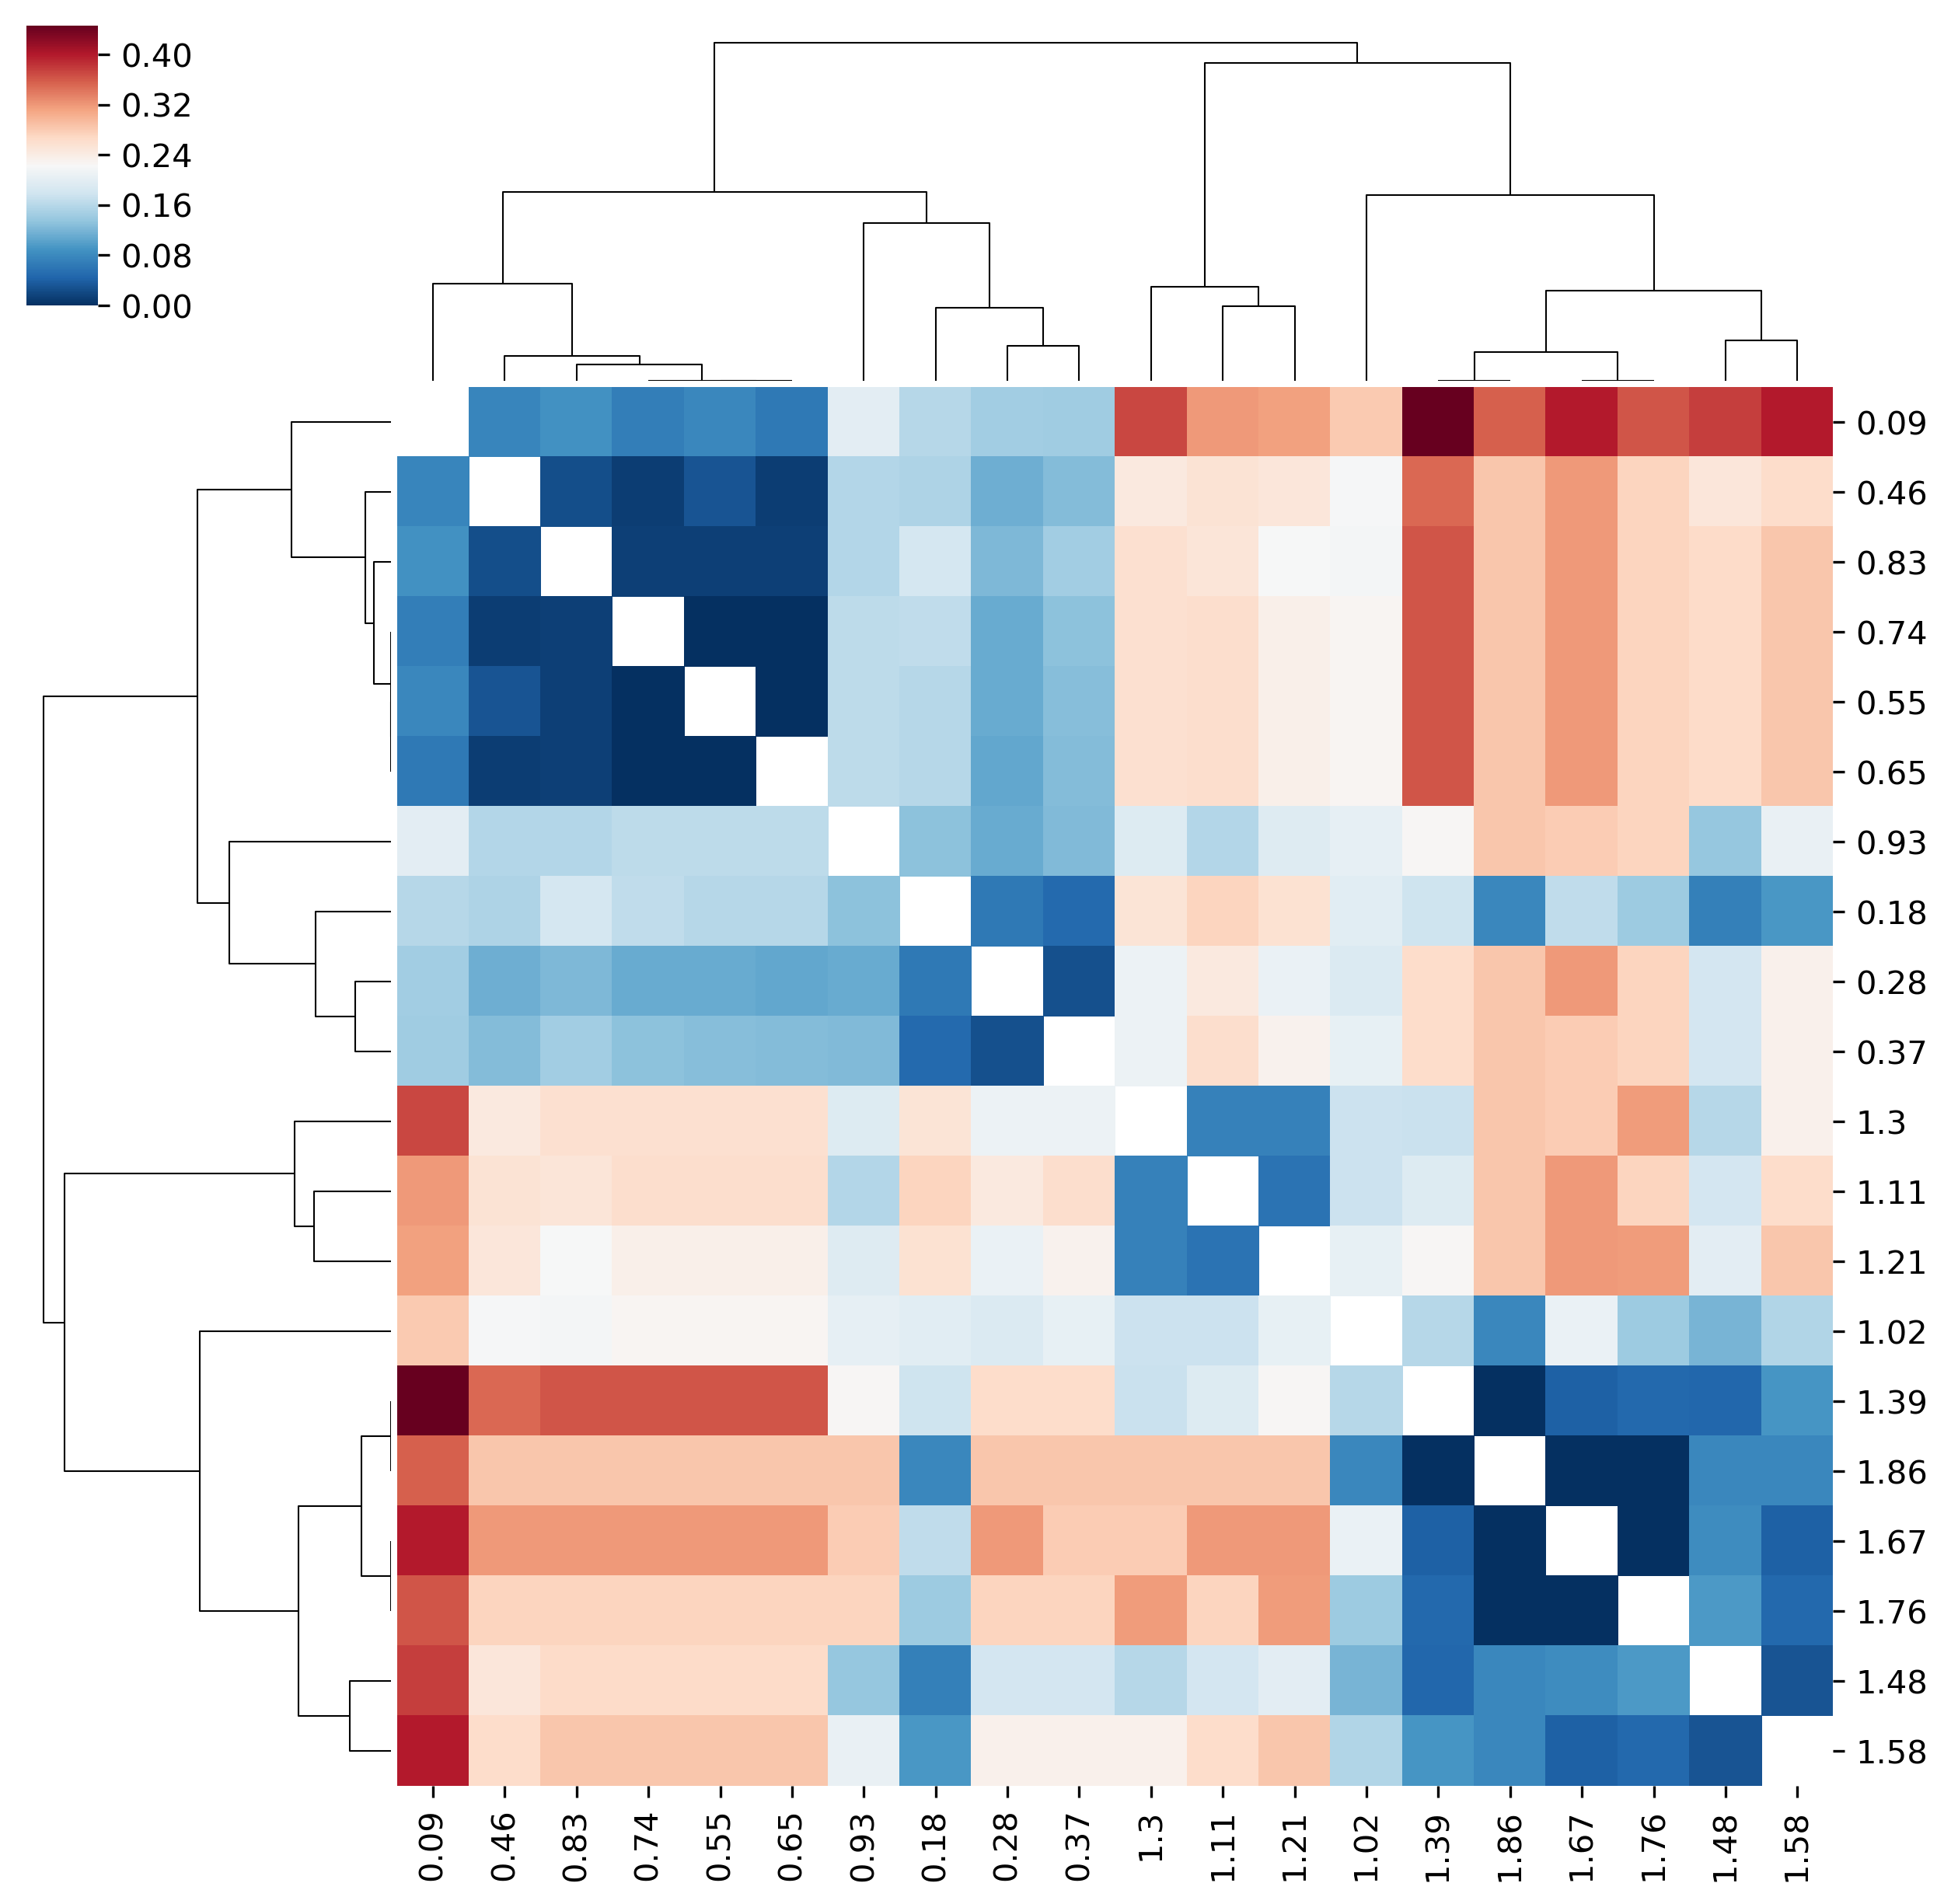

In [326]:
clst_map = sns.clustermap(jaccard,
                          row_linkage=linkage,
                          col_linkage=linkage,
                          cmap='RdBu_r');
clst_map.fig.set_dpi(300)

In [319]:
compatible_ratio = []
for thresh in distance_thresholds:
    tmp_df      = transfer_df[transfer_df.transfer_distance>=thresh]
    
    compatible_count = 0
    for line in open('maxtic_%.4f.input_MT_output_partial_order' % thresh).readlines():
        line = line.split()
        compatible_count += float(line[2])
    
    compatible_ratio.append(compatible_count/tmp_df.shape[0])

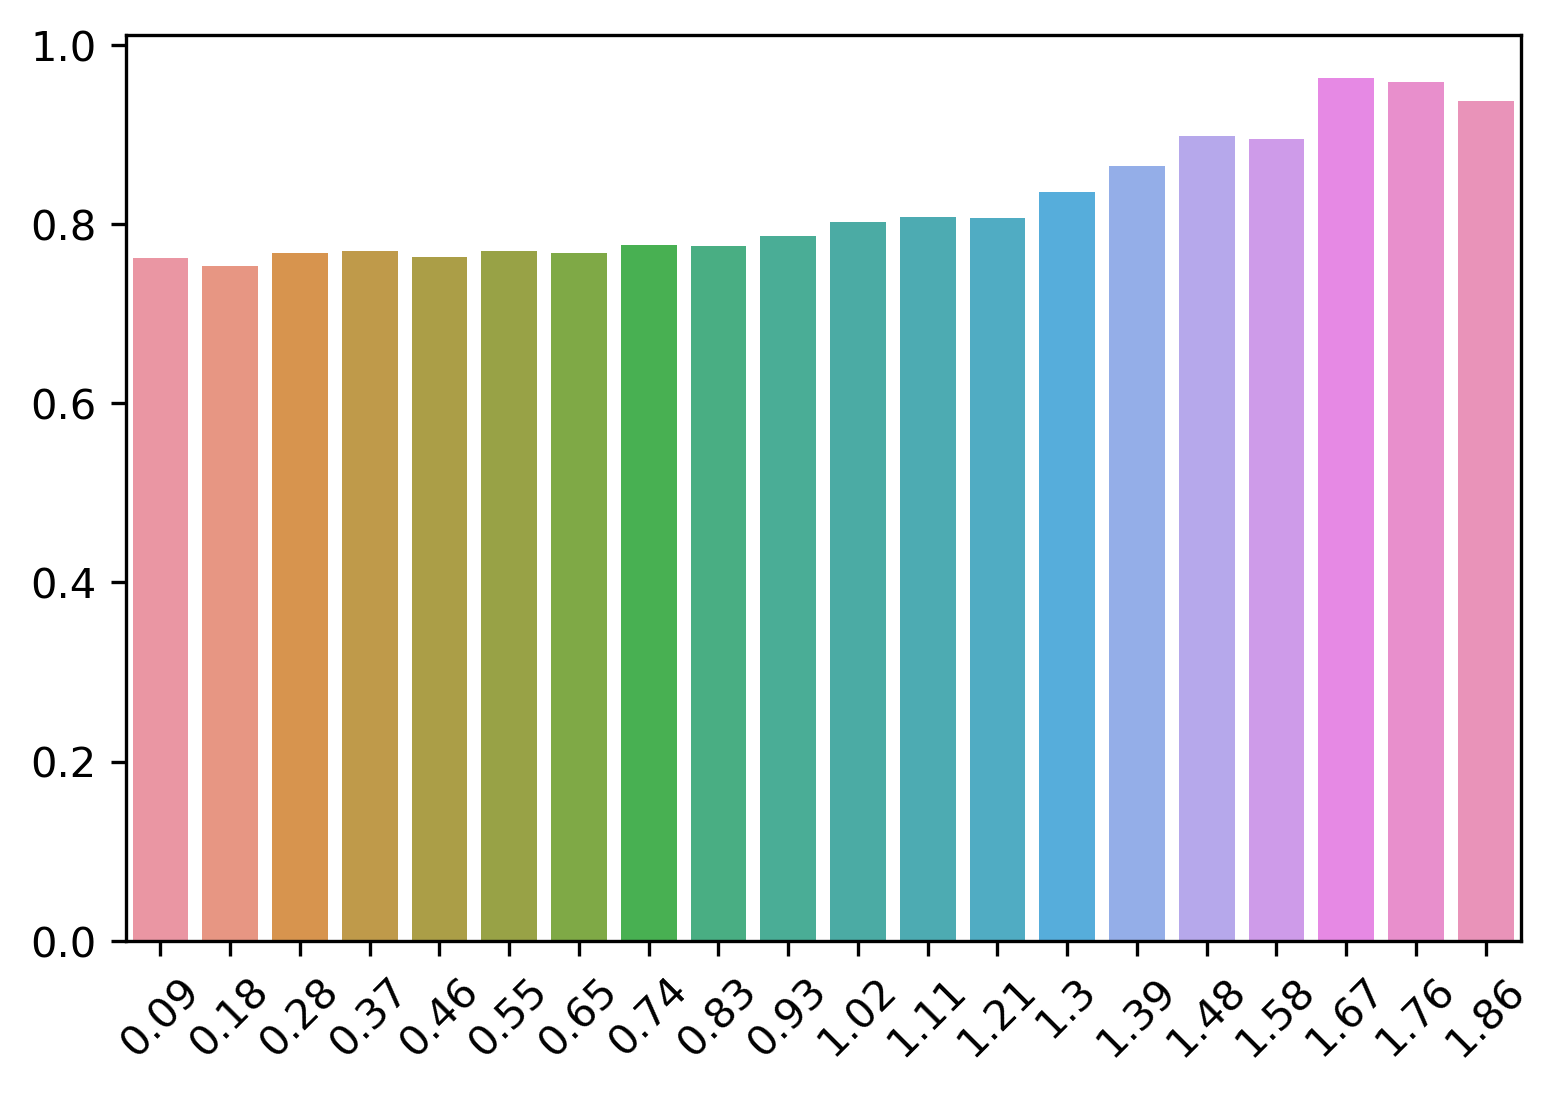

In [320]:
fig, ax = plt.subplots(dpi=300)
sns.barplot([round(n, 2) for n in distance_thresholds],
            compatible_ratio, ax=ax)
plt.xticks(rotation=45, ha='center');

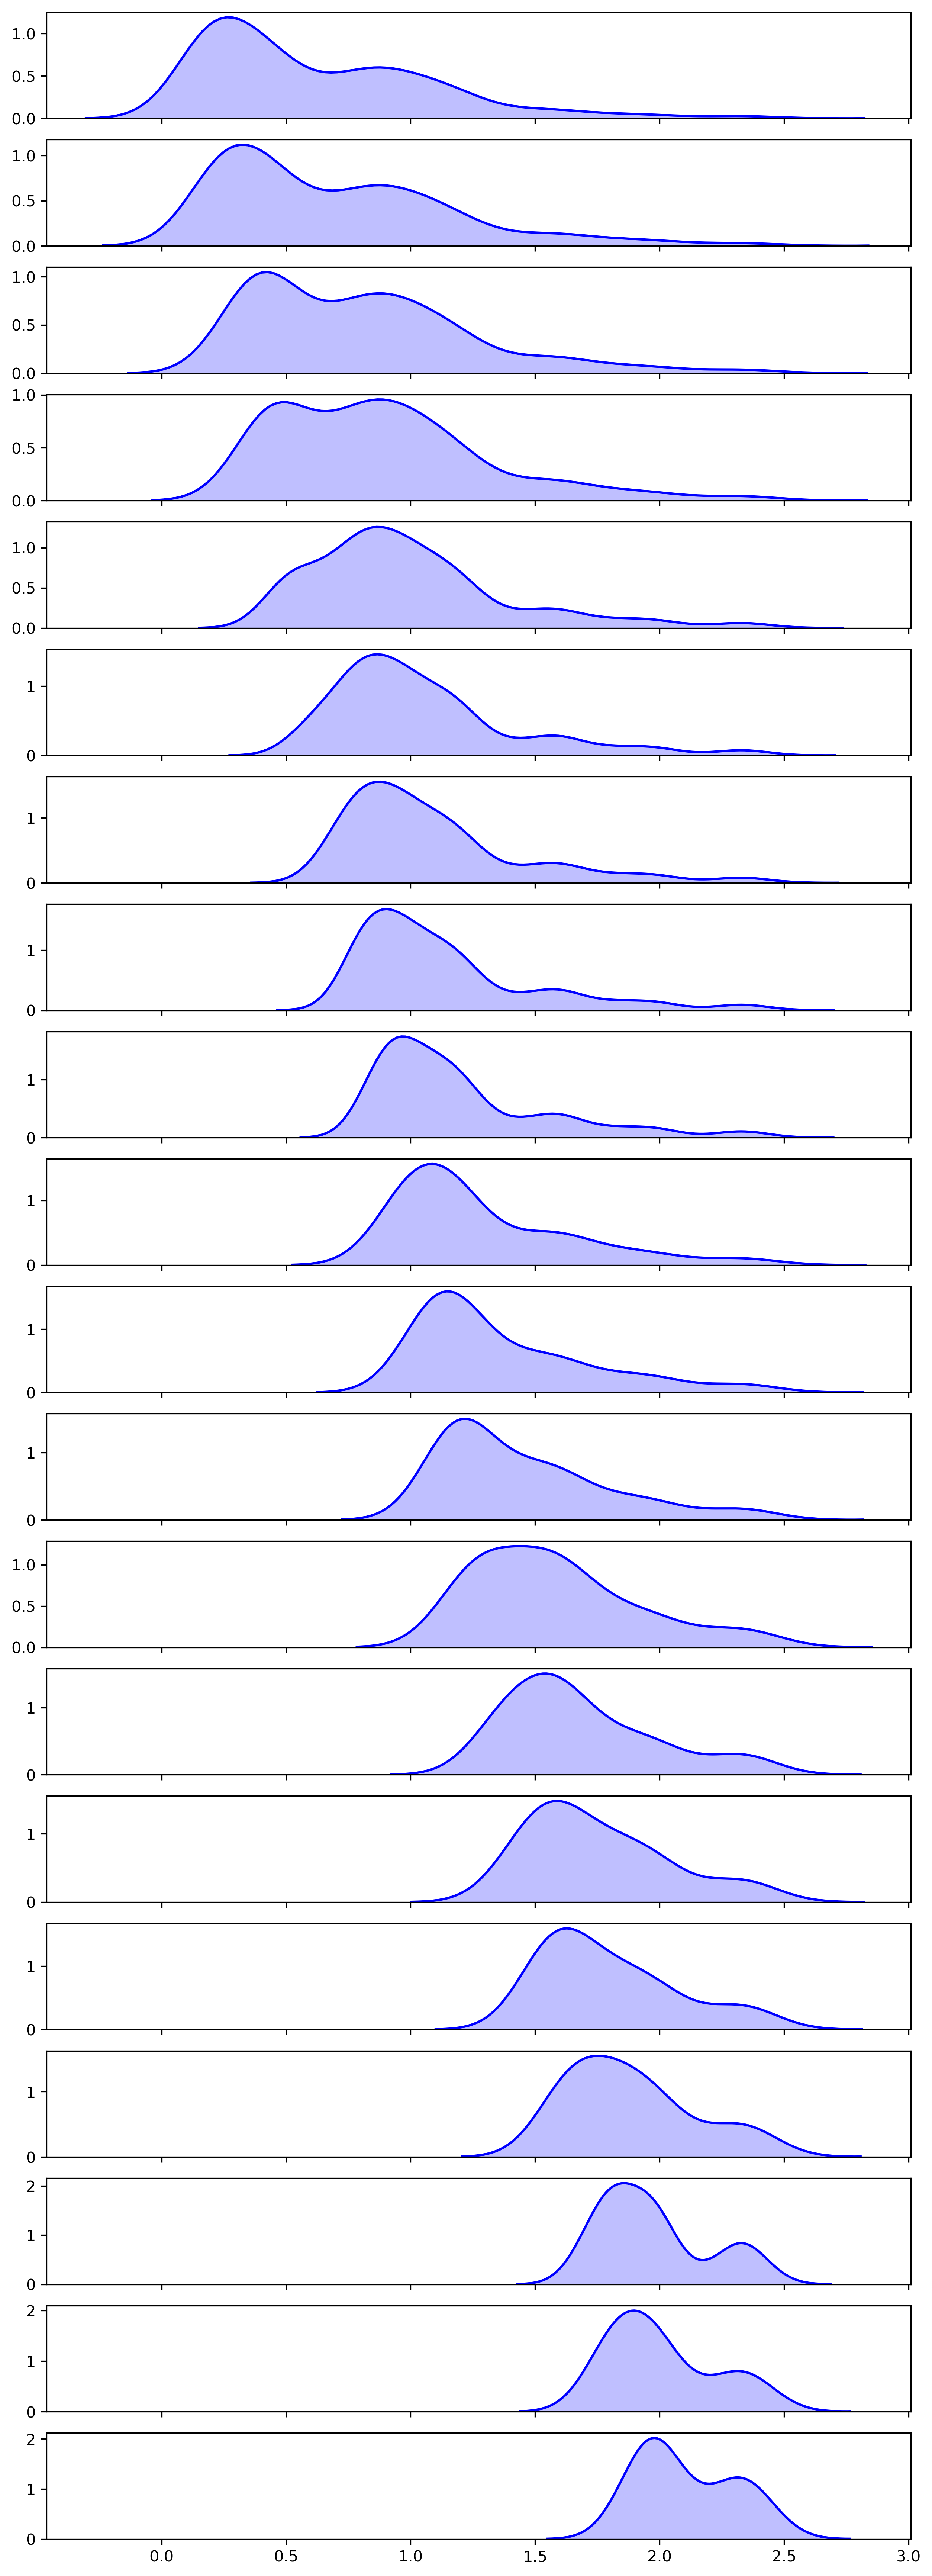

In [363]:
fig, axs = plt.subplots(dpi=300, figsize=(10,30), nrows=20, sharex=True)
for thresh, ax in zip(distance_thresholds, axs):
    tmp_df = transfer_df[transfer_df.transfer_distance>=thresh]
    
    compatible_pairs = set()
    for line in open('maxtic_%.4f.input_MT_output_partial_order' % thresh).readlines():
        line = line.split()
        compatible_count = float(line[2])
        compatible_pairs.add((line[0], line[1]))

    tmp_grouped = tmp_df.groupby(['donor', 'recipient'])
    
    distances_of_compatible_transfers   = []
    distances_of_incompatible_transfers = []
    for pair, indexes in tmp_grouped.groups.items():
        if pair in compatible_pairs:
            distances_of_compatible_transfers.extend(
                [donor_recipient_distances[pair]]*len(indexes)
            )
        else:
            distances_of_incompatible_transfers.extend(
                [donor_recipient_distances[pair]]*len(indexes)
            )
    sns.kdeplot(distances_of_compatible_transfers,   color='blue', shade=True, ax=ax)
    #sns.kdeplot(distances_of_incompatible_transfers, color='red',  shade=True, ax=ax)

In [360]:
patristic_distances = [species_tree.get_distance(leaf1, leaf2)
                       for leaf1, leaf2 in itertools.combinations(species_tree.get_leaf_names(), 2)]

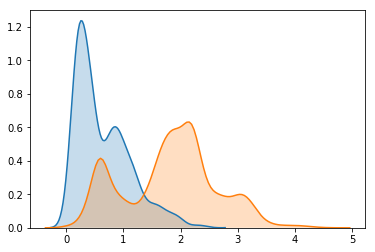

In [361]:
a = distances_of_compatible_transfers
a.extend(distances_of_incompatible_transfers)
fig, ax = plt.subplots()
sns.kdeplot(a, shade=True, ax=ax);
sns.kdeplot(patristic_distances, shade=True, ax=ax);

In [549]:
pair_order     = list(donor_recipients.groups.keys())
pair_weights   = np.array([len(donor_recipients.groups[pair]) for pair in pair_order])
pair_distances = np.array([donor_recipient_distances[pair]    for pair in pair_order])
weight_distance_ratio = [np.log10(n/m) for m, n in zip(pair_distances, pair_weights)]

In [582]:
def cutoff(x):
    values = []
    for _ in x:
        tmp = 0.81 - _*.0835

        values.append(tmp)
    return(values)

In [599]:
len(pair_distances)

526

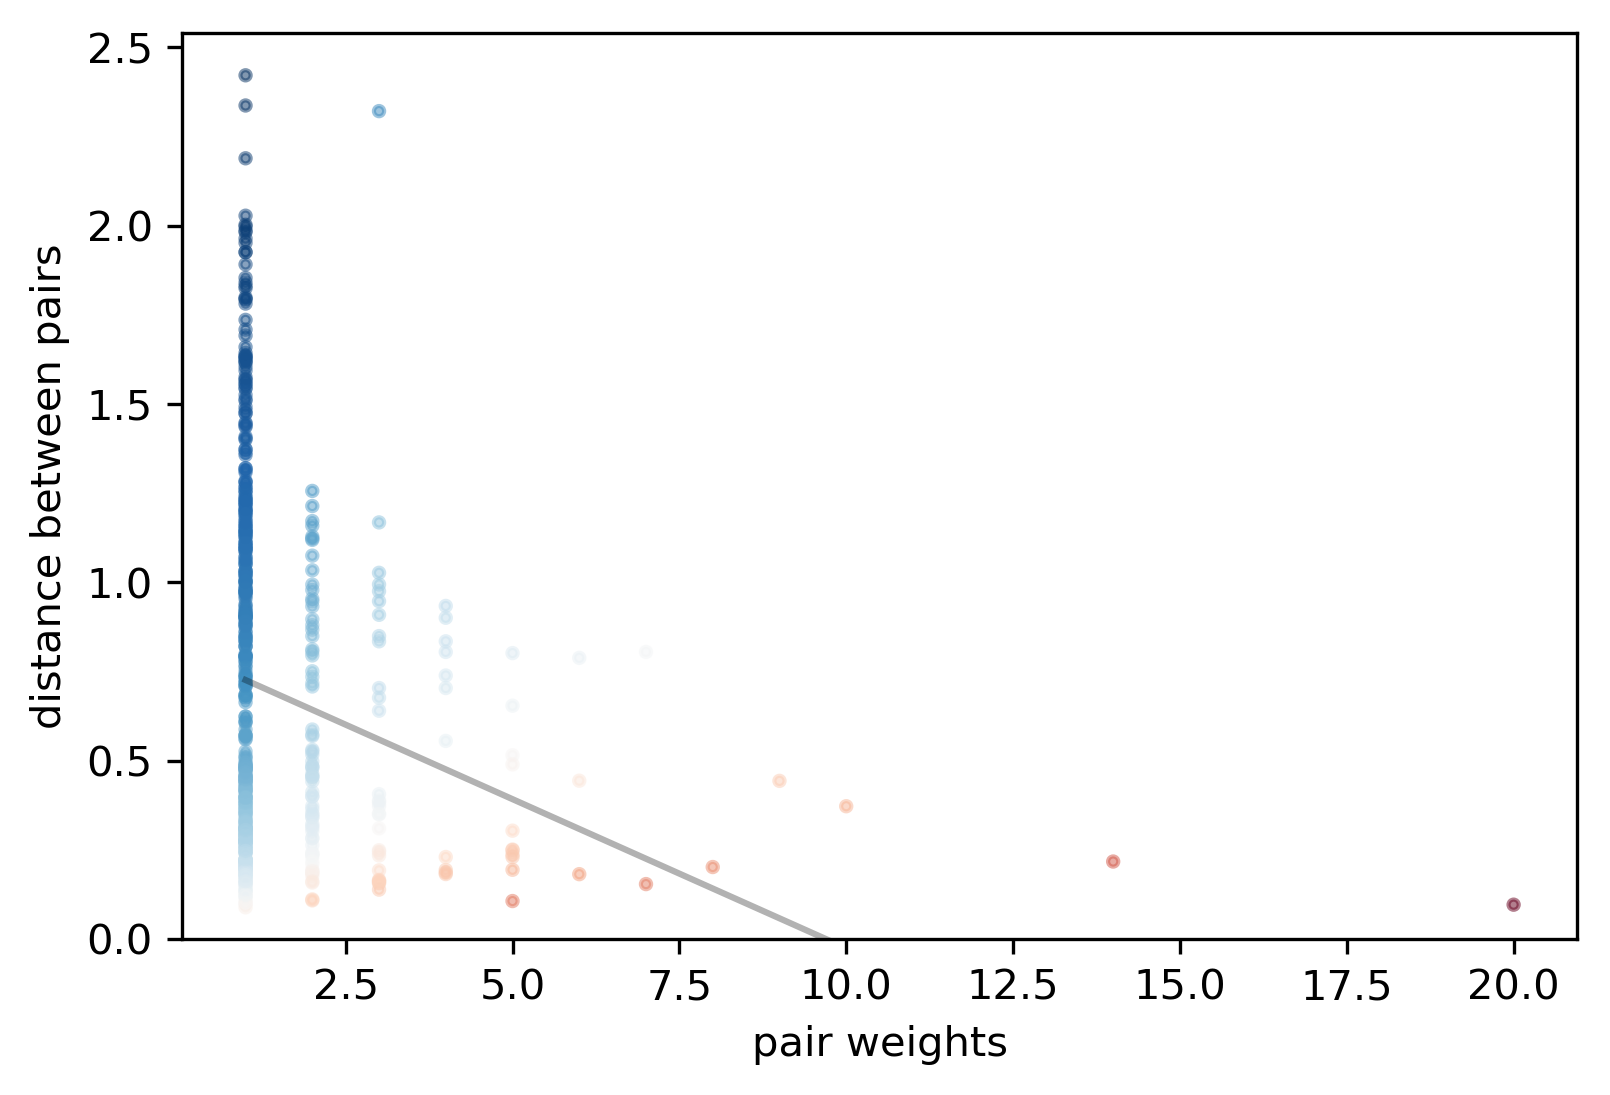

In [592]:
fig, ax = plt.subplots(dpi=300)
ax.scatter(x=pair_weights,
           y=pair_distances,
           c=weight_distance_ratio,
           cmap='RdBu_r',
           s=6,
           alpha=0.5);
ax.set_xlabel('pair weights')
ax.set_ylabel('distance between pairs')
ax.set_ylim(bottom=0)
ax.plot(sorted(pair_weights),
        cutoff(sorted(pair_weights)),
        'k-', alpha=0.3);

Text(0, 0.5, 'distance between pairs')

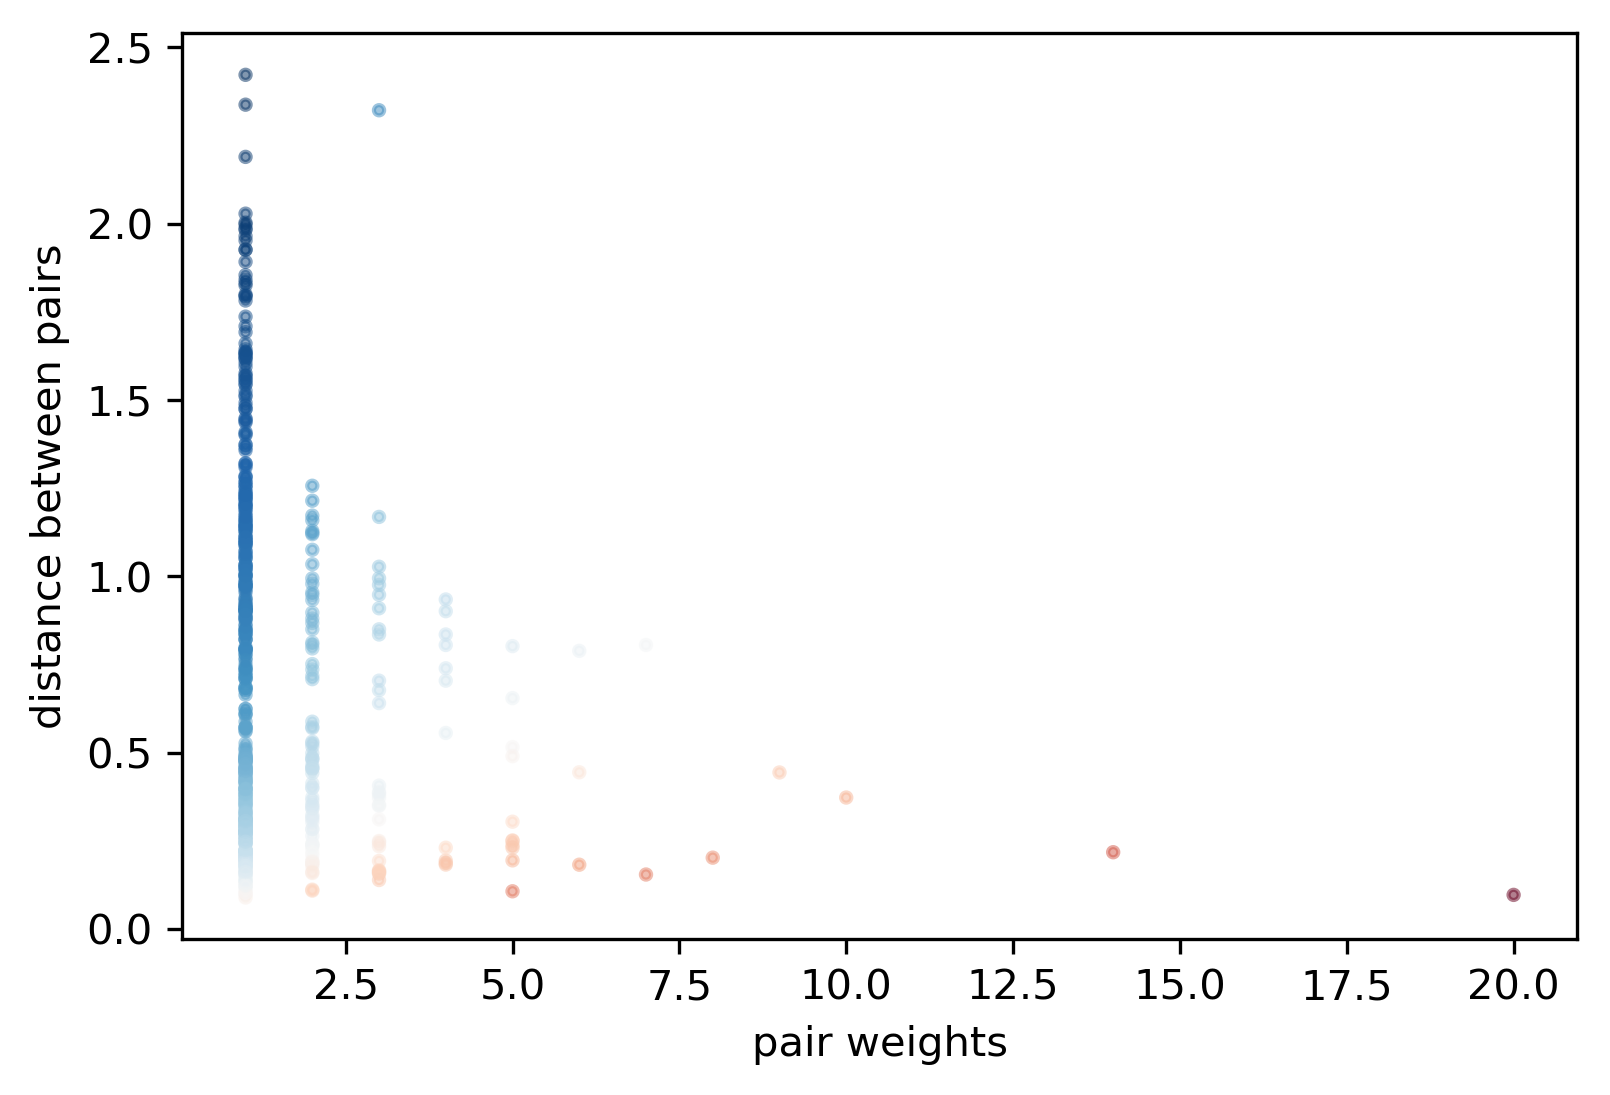

In [598]:
fig, ax = plt.subplots(dpi=300)
ax.scatter(x=pair_weights,
           y=pair_distances,
           c=weight_distance_ratio,
           cmap='RdBu_r',
           s=6,
           alpha=0.5);
ax.set_xlabel('pair weights')
ax.set_ylabel('distance between pairs')

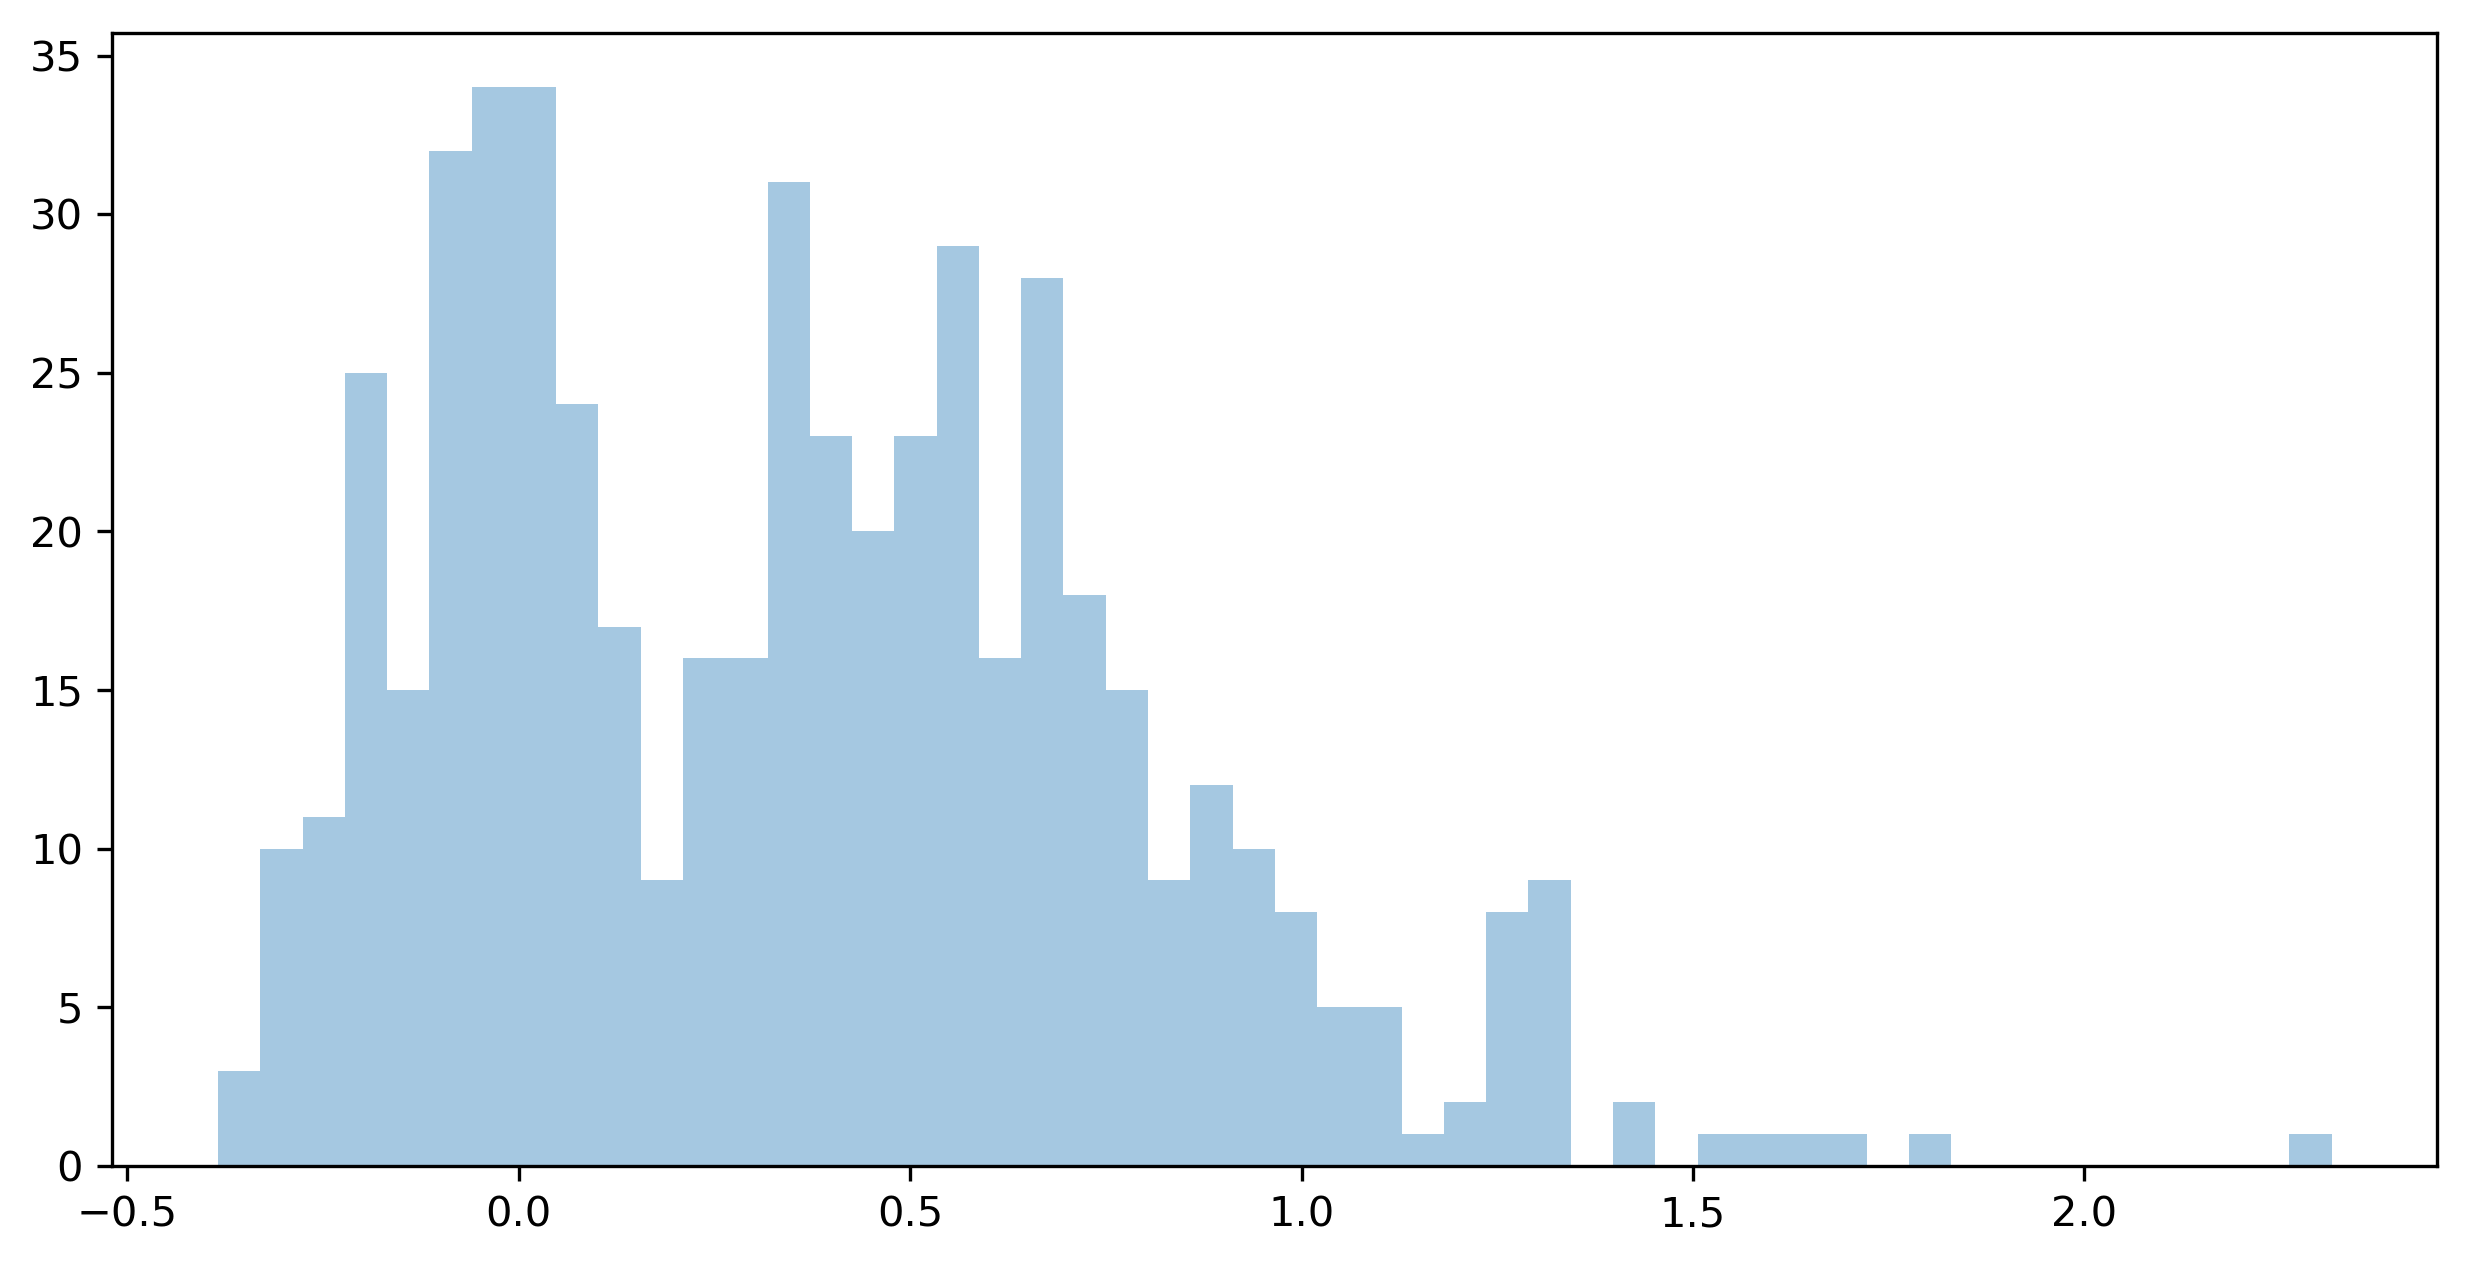

In [565]:
fig, ax = plt.subplots(dpi=300, figsize=(10,5))
sns.distplot([np.log10(m/n) for m, n in zip(pair_weights, pair_distances)],
             kde=False,
             ax=ax,
             bins=50)

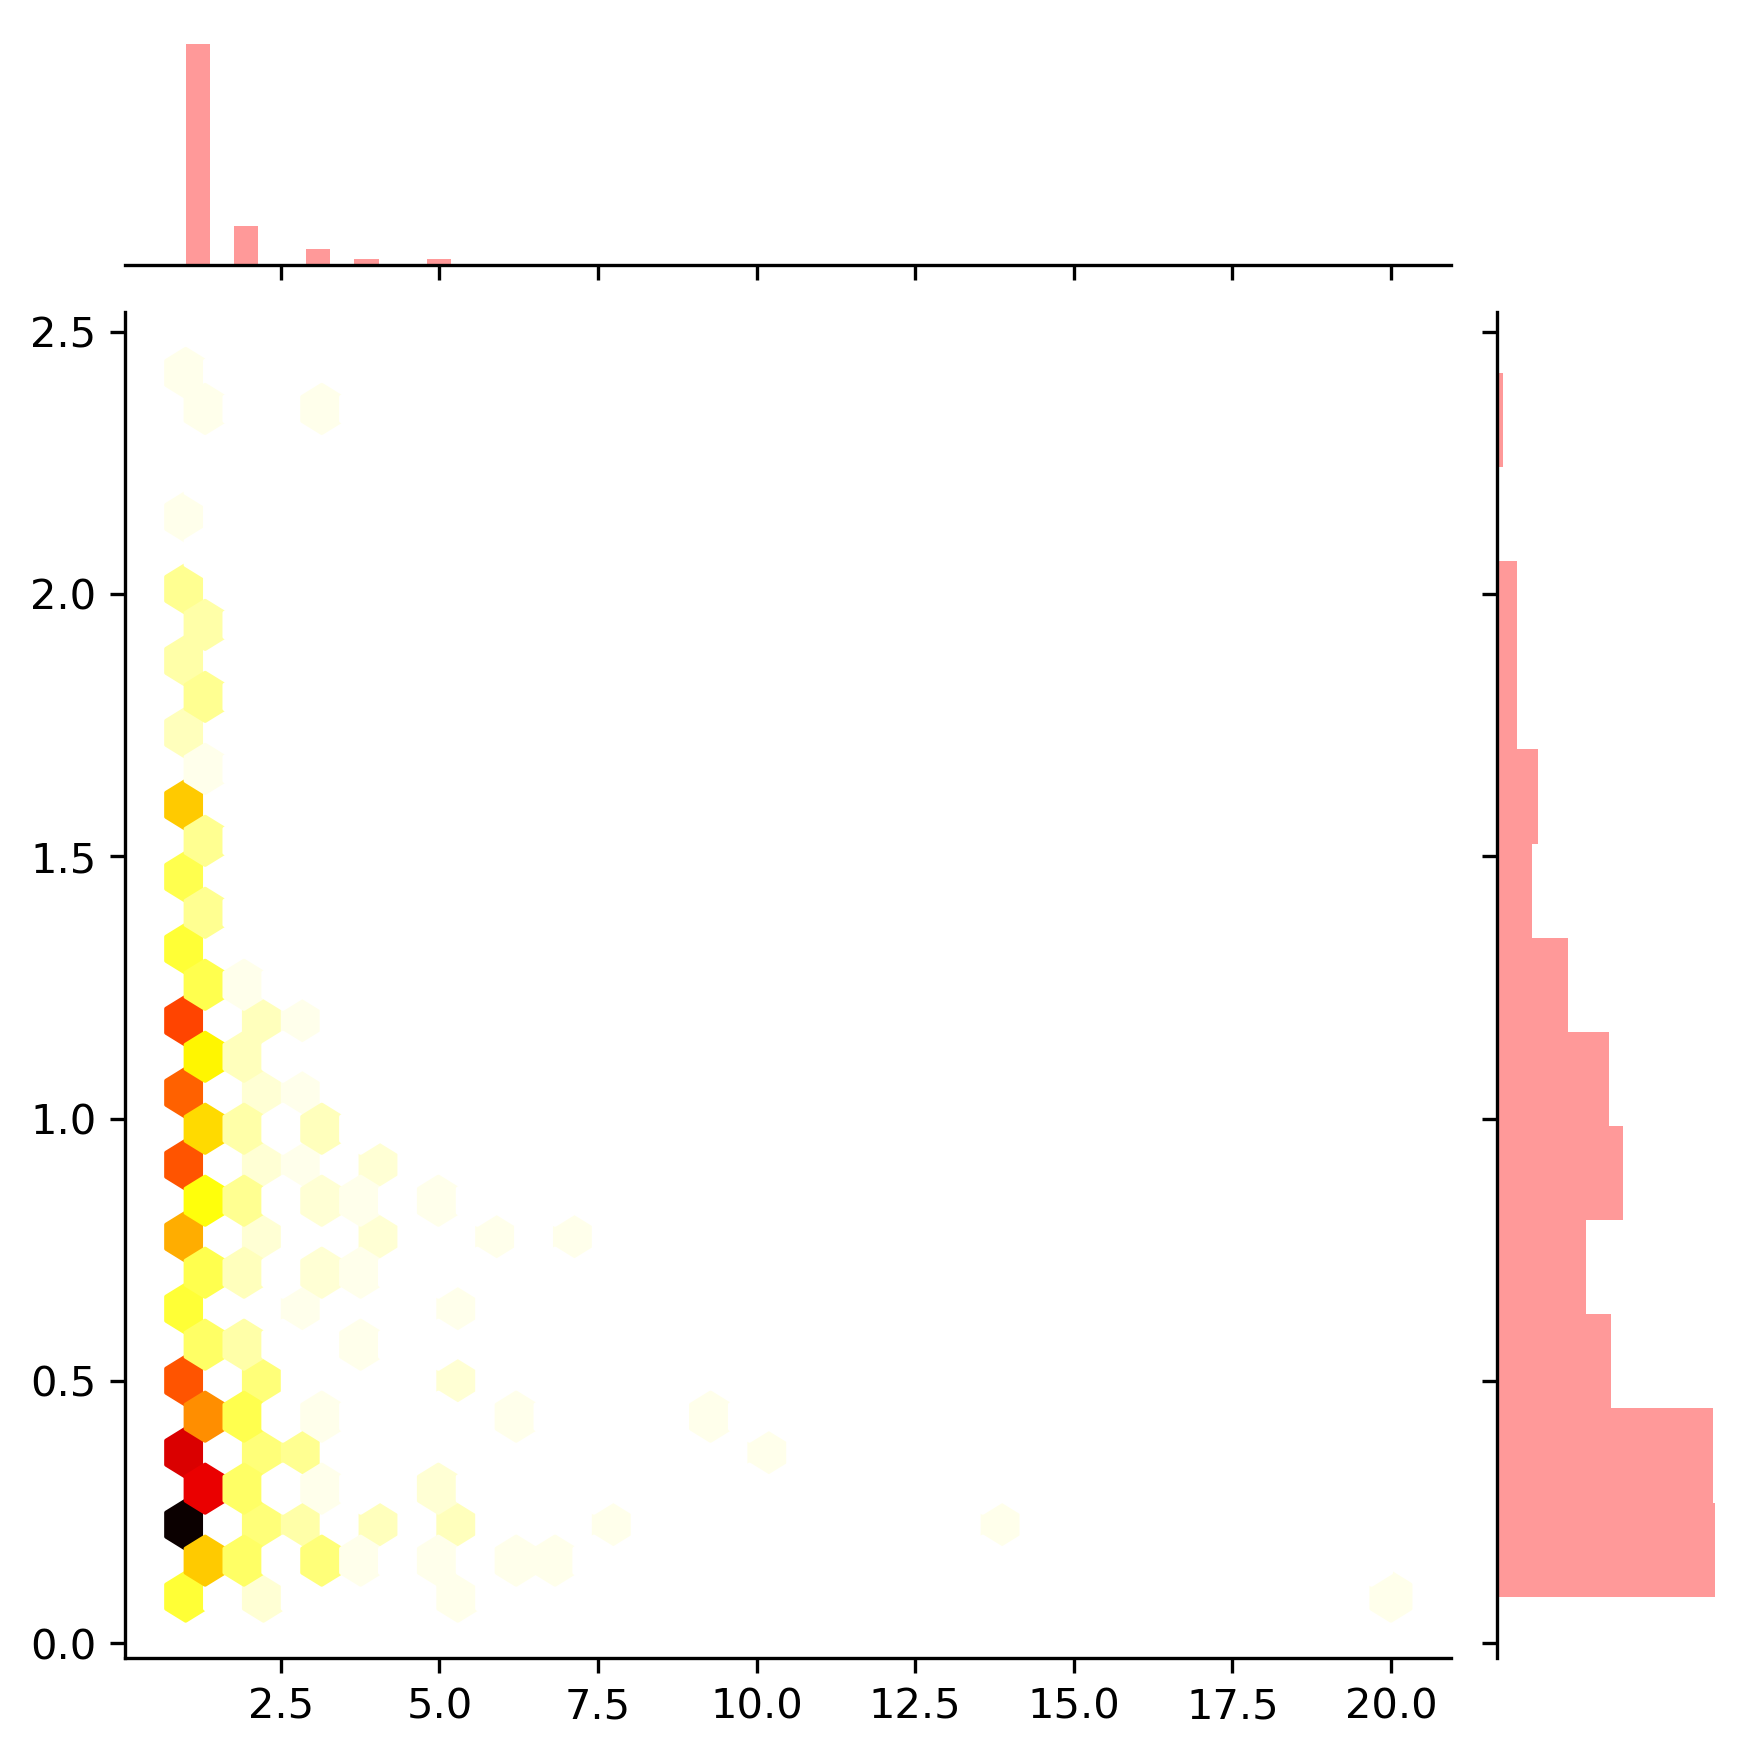

In [596]:
plot = sns.jointplot(x=pair_weights,
                     y=pair_distances,
                     kind='hex',
                     color='r',
                    joint_kws=dict(cmap='hot_r'));
plot.fig.set_dpi(300)

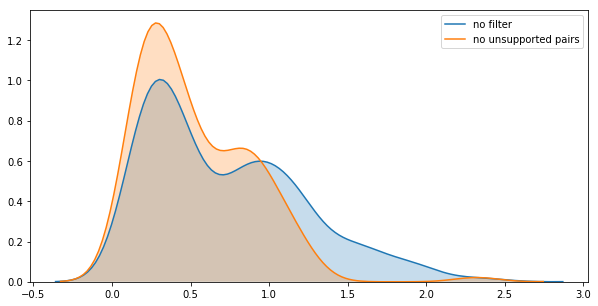

In [591]:
fig, ax = plt.subplots(figsize=(10,5))
sns.kdeplot(pair_distances,                 shade=True, label='no filter', ax=ax)
sns.kdeplot(pair_distances[pair_weights>1], shade=True, label='no unsupported pairs', ax=ax)

In [544]:
0.1/20

0.005